In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from skimage.io import imread
from skimage.transform import resize
import os

# Set paths to the images and masks
image_dir = 'N:\\My Drive\\Data\\RUH'
mask_dir = 'N:\\My Drive\\Data\\Mask'
# List of image and mask files
image_files = sorted(os.listdir(image_dir))[:25000]
mask_files = sorted(os.listdir(mask_dir))[:25000]

# Function to normalize images and encode masks
def prepare_data(img_path, mask_path):
    # Read the image and mask files
    img = imread(img_path) / 255.0  # Normalize to [0, 1]
    mask = imread(mask_path, as_gray=True)  # Read mask as grayscale
    # Resize images and masks if not already 256x256
    if img.shape[0] != 256 or img.shape[1] != 256:
        img = resize(img, (256, 256), anti_aliasing=True)
    if mask.shape[0] != 256 or mask.shape[1] != 256:
        mask = resize(mask, (256, 256), order=0, preserve_range=True)
    # Map mask pixel values to class labels
    mask[mask == 255] = 3
    mask[mask == 170] = 2
    mask[mask == 85] = 1
    mask[mask == 0] = 0
    # Convert mask to categorical
    mask = to_categorical(mask, num_classes=4)
    return img, mask

# Generator to load images in batches
def generate_batches(image_files, mask_files, batch_size):
    num_samples = len(image_files)
    while True:  # Loop indefinitely
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            images, masks = [], []
            for i in range(start, end):
                img_path = os.path.join(image_dir, image_files[i])
                mask_path = os.path.join(mask_dir, mask_files[i])
                img, mask = prepare_data(img_path, mask_path)
                images.append(img)
                masks.append(mask)
            yield np.array(images), np.array(masks)



In [8]:
from sklearn.model_selection import train_test_split

# Split the dataset into training plus validation set and test set (70% + 15% for train+val, 15% for test)
train_val_files, test_files, train_val_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.15, random_state=42)

# Split the training plus validation set into training and validation sets (82.35% of train_val for training, 17.65% for validation to maintain 15% of total as validation)
image_files_train, image_files_val, mask_files_train, mask_files_val = train_test_split(
    train_val_files, train_val_masks, test_size=0.1765, random_state=42)


# Define batch size
batch_size = 32

# Training and validation generator
train_generator = generate_batches(image_files_train, mask_files_train, batch_size)
val_generator = generate_batches(image_files_val, mask_files_val, batch_size)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)
    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the U-Net model
unet = unet_model()

# Display the model architecture
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,962,676 (7.49 MB)

 Trainable params: 1,962,676 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Function to compute weighted accuracy
def weighted_accuracy(y_true, y_pred):
    # Flatten and convert to argmax
    y_true_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_true, axis=-1))
    y_pred_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_pred, axis=-1))

    # Define class weights (adjust these values to reflect your class distribution)
    class_weights = np.array([0.1, 0.5, 1.5, 3.0], dtype='float32')

    # Create a boolean mask for each class and calculate weights
    weights = tf.gather(class_weights, y_true_f)
    matches = tf.keras.backend.cast(y_true_f == y_pred_f, 'float32')
    weighted_acc = tf.keras.backend.sum(matches * weights) / tf.keras.backend.sum(weights)
    return weighted_acc

# Function to compute mean IoU
def mean_iou(num_classes):
    def mean_iou_metric(y_true, y_pred):
        # Convert predictions to one-hot encoded arrays
        y_pred = tf.keras.backend.argmax(y_pred, axis=-1)
        y_true = tf.keras.backend.argmax(y_true, axis=-1)

        # Initialize IoU variables
        iou_scores = []

        for i in range(num_classes):
            # Create binary masks for the current class
            pred_mask = tf.keras.backend.cast(y_pred == i, 'float32')
            true_mask = tf.keras.backend.cast(y_true == i, 'float32')

            # Calculate intersection and union
            intersection = tf.keras.backend.sum(pred_mask * true_mask)
            union = tf.keras.backend.sum(pred_mask) + tf.keras.backend.sum(true_mask) - intersection

            # Ensure all calculations are float32
            intersection = tf.keras.backend.cast(intersection, 'float32')
            union = tf.keras.backend.cast(union, 'float32')

            # Avoid division by zero
            iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
            iou_scores.append(iou)

        # Compute mean IoU
        mean_iou_value = tf.keras.backend.mean(tf.stack(iou_scores))
        return mean_iou_value

    return mean_iou_metric

# Update model compilation to include both metrics
num_classes = 4  # Adjust this according to your use case
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[mean_iou(num_classes), weighted_accuracy, 'accuracy']
)# Function to compute weighted accuracy
def weighted_accuracy(y_true, y_pred):
    # Flatten and convert to argmax
    y_true_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_true, axis=-1))
    y_pred_f = tf.keras.backend.flatten(tf.keras.backend.argmax(y_pred, axis=-1))

    # Define class weights (adjust these values to reflect your class distribution)
    class_weights = np.array([0.1, 0.5, 1.5, 3.0], dtype='float32')

    # Create a boolean mask for each class and calculate weights
    weights = tf.gather(class_weights, y_true_f)
    matches = tf.keras.backend.cast(y_true_f == y_pred_f, 'float32')
    weighted_acc = tf.keras.backend.sum(matches * weights) / tf.keras.backend.sum(weights)
    return weighted_acc

# Function to compute mean IoU
def mean_iou(num_classes):
    def mean_iou_metric(y_true, y_pred):
        # Convert predictions to one-hot encoded arrays
        y_pred = tf.keras.backend.argmax(y_pred, axis=-1)
        y_true = tf.keras.backend.argmax(y_true, axis=-1)

        # Initialize IoU variables
        iou_scores = []

        for i in range(num_classes):
            # Create binary masks for the current class
            pred_mask = tf.keras.backend.cast(y_pred == i, 'float32')
            true_mask = tf.keras.backend.cast(y_true == i, 'float32')

            # Calculate intersection and union
            intersection = tf.keras.backend.sum(pred_mask * true_mask)
            union = tf.keras.backend.sum(pred_mask) + tf.keras.backend.sum(true_mask) - intersection

            # Ensure all calculations are float32
            intersection = tf.keras.backend.cast(intersection, 'float32')
            union = tf.keras.backend.cast(union, 'float32')

            # Avoid division by zero
            iou = (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())
            iou_scores.append(iou)

        # Compute mean IoU
        mean_iou_value = tf.keras.backend.mean(tf.stack(iou_scores))
        return mean_iou_value

    return mean_iou_metric                                                                                 

# Update model compilation to include both metrics
num_classes = 4  # Adjust this according to your use case
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[mean_iou(num_classes), weighted_accuracy, 'accuracy']
)

# Define callbacks for saving the model and early stopping
model_checkpoint = ModelCheckpoint('U-Net.2.keras', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training the model
history = unet.fit(
    x=train_generator,
    y=None,  # Since the generator yields both images and masks, y is not separately provided
    batch_size=None,  # Batch size is handled by the generator
    epochs=30,
    steps_per_epoch=int(np.ceil(len(image_files_train) / batch_size)),  # Convert to int
    validation_data=val_generator,
    validation_steps=int(np.ceil(len(image_files_val) / batch_size)),  # Convert to int
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1439s 3s/step - accuracy: 0.7969 - loss: 0.5630 - mean_iou_metric: 0.2016 - weighted_accuracy: 0.6011 - val_accuracy: 0.9371 - val_loss: 0.1918 - val_mean_iou_metric: 0.2344 - val_weighted_accuracy: 0.6957
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1400s 3s/step - accuracy: 0.9367 - loss: 0.1836 - mean_iou_metric: 0.2549 - weighted_accuracy: 0.7029 - val_accuracy: 0.9424 - val_loss: 0.1693 - val_mean_iou_metric: 0.3381 - val_weighted_accuracy: 0.7552
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1340s 2s/step - accuracy: 0.9418 - loss: 0.1664 - mean_iou_metric: 0.3362 - weighted_accuracy: 0.7541 - val_accuracy: 0.9448 - val_loss: 0.1598 - val_mean_iou_metric: 0.3683 - val_weighted_accuracy: 0.7784
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.9454 - loss: 0.1560 - mean_iou_metric: 0.3749 - weighted_accuracy: 0.7813 - val_accuracy: 0.9468 - val_loss: 0.1518 - val_mean_iou_metric: 0.3939 - val_weighted_accuracy: 0.7984
Epoch 5/30
547/5

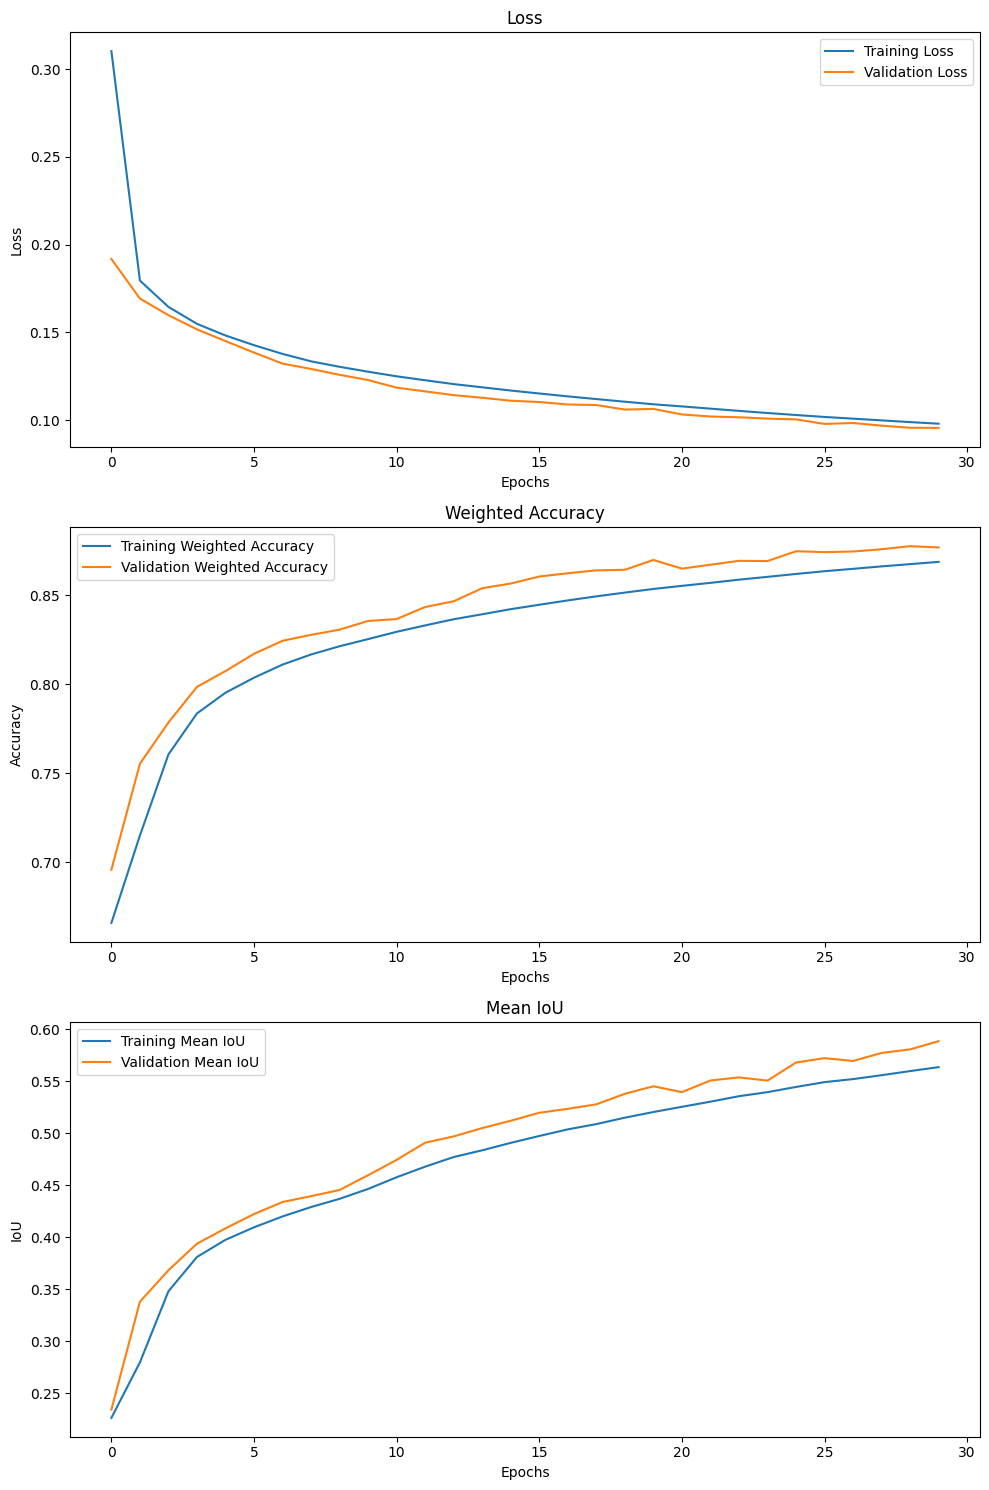

In [10]:
import matplotlib.pyplot as plt

# Function to plot metrics
def plot_training_history(history):
    # Extract data from the history object
    metrics = history.history

    # Set up subplots for the different metrics
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    
    # Plot loss
    axs[0].plot(metrics['loss'], label='Training Loss')
    axs[0].plot(metrics['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot weighted accuracy
    axs[1].plot(metrics['weighted_accuracy'], label='Training Weighted Accuracy')
    axs[1].plot(metrics['val_weighted_accuracy'], label='Validation Weighted Accuracy')
    axs[1].set_title('Weighted Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Plot mean IoU
    axs[2].plot(metrics['mean_iou_metric'], label='Training Mean IoU')
    axs[2].plot(metrics['val_mean_iou_metric'], label='Validation Mean IoU')
    axs[2].set_title('Mean IoU')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('IoU')
    axs[2].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Assuming `history` is the object returned from your training process:
plot_training_history(history)


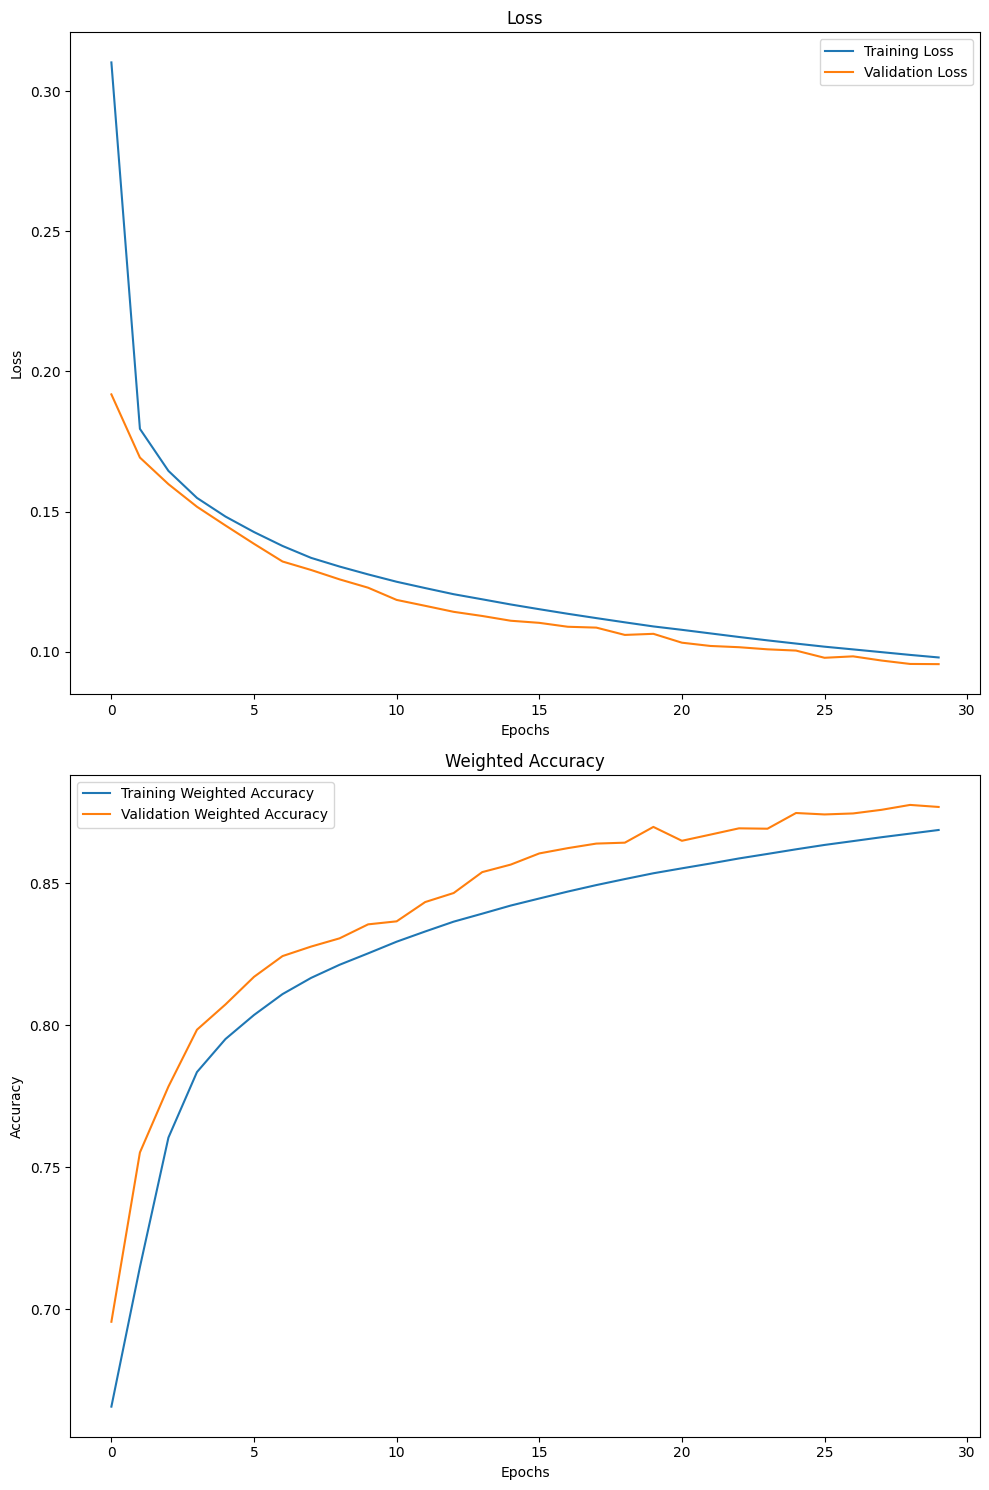

In [11]:
import matplotlib.pyplot as plt

# Function to plot metrics
def plot_training_history(history):
    # Extract data from the history object
    metrics = history.history

    # Set up subplots for the different metrics
    fig, axs = plt.subplots(2, 1, figsize=(10, 15))
    
    # Plot loss
    axs[0].plot(metrics['loss'], label='Training Loss')
    axs[0].plot(metrics['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot weighted accuracy
    axs[1].plot(metrics['weighted_accuracy'], label='Training Weighted Accuracy')
    axs[1].plot(metrics['val_weighted_accuracy'], label='Validation Weighted Accuracy')
    axs[1].set_title('Weighted Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Assuming `history` is the object returned from your training process:
plot_training_history(history)